## Sports Celebrity Face Recognition Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 as cv

### Using OpenCV to read and detect faces in images

In [2]:
img = cv.imread("./test_images/sharapova1.jpg")

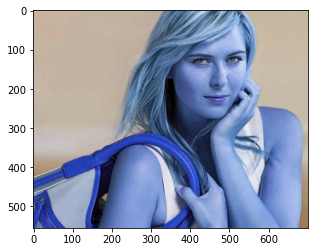

In [3]:

plt.imshow(img)
plt.show()

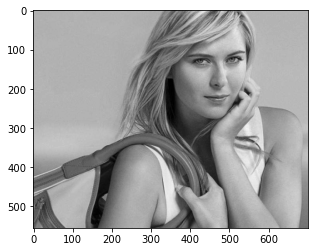

In [4]:
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')

### How to focus on face

In [5]:
face_cascade  =   cv.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')

In [6]:
face = face_cascade.detectMultiScale(gray)
face

array([[355,  39, 230, 230]])

In [7]:
(x,y,w,h) = face[0]
x,y,w,h

(355, 39, 230, 230)

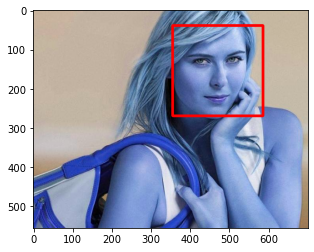

In [8]:
face_rect  =  cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)
plt.imshow(face_rect,cmap="gray")

### Now we will focus on eyes

In [9]:
cv.destroyAllWindows()
face_img =  gray[y:y+h,x:x+w]
eye_cascade  =  cv.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
eye = eye_cascade.detectMultiScale(img)

In [10]:
eye

array([[486, 103,  46,  46],
       [536, 202,  23,  23],
       [457, 184,  23,  23],
       [403, 105,  49,  49]])

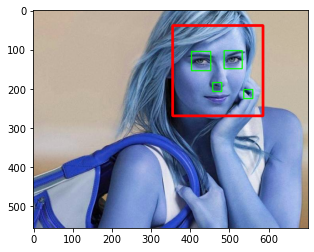

In [11]:
for (ex,ey,ew,eh) in eye:
    cv.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    
plt.figure()
plt.imshow(img,cmap='gray')
plt.show()

### Now we will create a function which will take an image and return cropped image

In [12]:
def cropped(img_path):
    img = cv.imread(img_path)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    face_cascade  =   cv.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
    eye_cascade  =  cv.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(gray)
    for (x,y,w,h) in faces:
        gray_crop =  gray[y:y+h,x:x+w]
        col_crop  =  img[y:y+h,x:x+w]
        eye = eye_cascade.detectMultiScale(gray_crop)
        if len(eye)>= 2:
            
            return col_crop
    

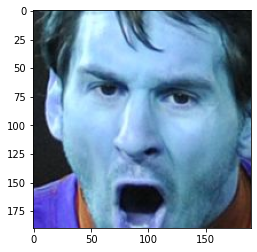

In [13]:
crop  = cropped("./dataset/lionel_messi/136054219.jpg.0.jpg")
plt.imshow(crop)

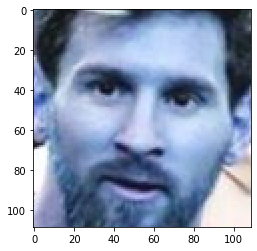

In [14]:
crop  = cropped("./dataset/lionel_messi/messi-940x529.jpg")
plt.imshow(crop)

In [15]:
import os,shutil

In [16]:
dict = {}
if os.path.exists("./dataset/cropped"):
    
    shutil.rmtree("./dataset/cropped")
    
    
for entry in os.listdir('./dataset/'):
    
    dict[entry] = []
    print(entry)
    count =1   
        
    for image in os.listdir("./dataset/"+entry):
        
        cropped_img = cropped("./dataset/"+entry+"/"+image)
        if cropped_img is not None:

            
            path = "./dataset/cropped/" + entry
            if not os.path.exists(path):
                
                os.makedirs(path)
                    
            cv.imwrite(path+"/" + entry +str(count)+'.png', cropped_img)
            
            dict[entry].append(path+"/"+entry+str(count)+'.png')
            count = count +1

.ipynb_checkpoints
lionel_messi
maria_sharapova
roger_federer
serena_williams
virat_kohli


In [17]:
#sys.exit()

### Now we will perform wavelet transformation for extracting imp features from face

In [18]:
import pywt


def trans(img,mode='haar',level=1):
    # convert into grayscale
    imarray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
    # convert into float
    imarray = np.float32(imarray)
    imarray = imarray/255
    # compute coefficients
    coeff = pywt.wavedec2(imarray,mode,level=level)
    coeff[0] = 0*coeff[0]
    # reconstruction
    imarray_transf = pywt.waverec2(coeff,mode)
    imarray_transf = 255* imarray_transf
    imarray_transf = np.uint8(imarray_transf)
    return imarray_transf

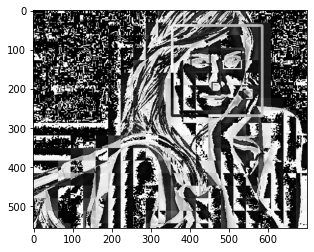

In [19]:
t=trans(img,'db1',5)
plt.imshow(t,cmap='gray')

In [20]:
dict.pop('.ipynb_checkpoints')

[]

In [21]:
count = 0
class_dict ={}
for celebrity_name in dict.keys():
    class_dict[celebrity_name] = count
    count = count +1
print(class_dict) 

{'lionel_messi': 0, 'maria_sharapova': 1, 'roger_federer': 2, 'serena_williams': 3, 'virat_kohli': 4}


In [22]:
X =[]
y=[]


for celebrity_name,image_loc in dict.items():
    
    for images_loc in image_loc:
        image =cv.imread(images_loc)
        if image is None :
            continue
        scaled_img = cv.resize(image,(32,32))
        transform_img = trans(image,'db1',5)
        scaled_trans_img = cv.resize(transform_img,(32,32)) 
        combined_img = np.vstack((scaled_img.reshape(32*32*3,1),scaled_trans_img.reshape(32*32,1)))
        X.append(combined_img)
        y.append(celebrity_name)
    
        
    

In [23]:
X = np.array(X).reshape(len(X),4096).astype(float)

## Now we will train our model (using SVM classifier)

In [24]:
from sklearn.svm import SVC #using SVM classifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [25]:
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=0)

In [26]:
pipe = Pipeline([("scalar",StandardScaler()),("svm",SVC(kernel ='linear',C=10))])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.6567164179104478

In [27]:
print(classification_report(y_test,pipe.predict(X_test)))

                 precision    recall  f1-score   support

   lionel_messi       0.60      0.75      0.67        12
maria_sharapova       0.75      0.75      0.75        16
  roger_federer       0.58      0.64      0.61        11
serena_williams       0.75      0.35      0.48        17
    virat_kohli       0.62      0.91      0.74        11

       accuracy                           0.66        67
      macro avg       0.66      0.68      0.65        67
   weighted avg       0.68      0.66      0.64        67

